# Stock Price Prediction: Data Analysis, Model Training, and Evaluation


# Code Imports and Setup

This section includes all the necessary library imports and initializations required for data analysis, model building, and evaluation.

## Libraries Imported:
1. **Data Manipulation and Numerical Computations**
   - `pandas`: For handling and processing tabular data.
   - `numpy`: For numerical operations and array manipulations.

2. **Model Building and Tuning**
   - `TimeSeriesSplit`: A cross-validator for time-series data, ensuring no data leakage.
   - `RandomizedSearchCV`: For hyperparameter tuning with randomized sampling.
   - `LinearRegression`: Simple linear regression model.
   - `RandomForestRegressor`: Ensemble-based regression model.
   - `GradientBoostingRegressor`: Boosted tree-based regression model.

3. **Model Evaluation Metrics**
   - `mean_squared_error`: To calculate the average squared difference between actual and predicted values.
   - `mean_absolute_error`: To calculate the average absolute difference between actual and predicted values.
   - `r2_score`: To measure the proportion of variance explained by the model.

4. **Visualization**
   - `matplotlib.pyplot`: For visualizing results and predictions.

5. **Data Download**
   - `yfinance`: To fetch financial stock data directly from Yahoo Finance.

In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import yfinance as yf


# Data Loading and Preprocessing for Stock Price Analysis

## 1. Data Loading
The dataset is downloaded using the `yfinance` library for Microsoft (MSFT) stock prices from January 1, 2010, to January 1, 2024. This dataset includes standard financial data such as open, close, high, and low prices.

```python
data = yf.download('MSFT', start='2010-01-01', end='2024-01-01')


In [23]:
# 1. Load and preprocess data
data = yf.download('MSFT', start='2010-01-01', end='2024-01-01')
data['High_Low_Diff'] = data['High'] - data['Low']
data['Close_Open_Diff'] = data['Close'] - data['Open']

# Add percentage change target
data['Adj_Close_Pct_Change'] = data['Adj Close'].pct_change()

# Add lag features (ensure no leakage)
for lag in range(1, 11):
    data[f'Lag_{lag}'] = data['Adj_Close_Pct_Change'].shift(lag)

# Drop rows with missing values caused by lagging and percentage change
data = data.dropna()

# Define features and target
X = data[['High_Low_Diff', 'Close_Open_Diff'] + [f'Lag_{lag}' for lag in range(1, 11)]]
y = data['Adj_Close_Pct_Change']

# Split data into training and testing sets
train = data[:'2022-12-31']
test = data['2023-01-01':'2023-12-01']

X_train = train[['High_Low_Diff', 'Close_Open_Diff'] + [f'Lag_{lag}' for lag in range(1, 11)]]
y_train = train['Adj_Close_Pct_Change']
X_test = test[['High_Low_Diff', 'Close_Open_Diff'] + [f'Lag_{lag}' for lag in range(1, 11)]]
y_test = test['Adj_Close_Pct_Change']

[*********************100%***********************]  1 of 1 completed


In [28]:
data.head()

Price,Adj Close,Close,High,Low,Open,Volume,High_Low_Diff,Close_Open_Diff,Adj_Close_Pct_Change,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9,Lag_10
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT,MSFT,,,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,
2010-01-20,23.029654,30.590000,30.940001,30.309999,30.809999,54849500,0.630001,-0.219999,-0.016399,0.007777,-0.003230,0.020099,0.009311,-0.006607,-0.012721,0.006897,-0.010400,-0.006137,0.000323
2010-01-21,22.593002,30.010000,30.719999,30.000000,30.610001,73086700,0.719999,-0.600000,-0.018960,-0.016399,0.007777,-0.003230,0.020099,0.009311,-0.006607,-0.012721,0.006897,-0.010400,-0.006137
2010-01-22,21.802511,28.959999,30.200001,28.840000,30.000000,102004600,1.360001,-1.040001,-0.034988,-0.018960,-0.016399,0.007777,-0.003230,0.020099,0.009311,-0.006607,-0.012721,0.006897,-0.010400
2010-01-25,22.073540,29.320000,29.660000,29.100000,29.240000,63373000,0.559999,0.080000,0.012431,-0.034988,-0.018960,-0.016399,0.007777,-0.003230,0.020099,0.009311,-0.006607,-0.012721,0.006897
2010-01-26,22.209051,29.500000,29.850000,29.090000,29.200001,66639900,0.760000,0.299999,0.006139,0.012431,-0.034988,-0.018960,-0.016399,0.007777,-0.003230,0.020099,0.009311,-0.006607,-0.012721


In [29]:
data.columns

MultiIndex([(           'Adj Close', 'MSFT'),
            (               'Close', 'MSFT'),
            (                'High', 'MSFT'),
            (                 'Low', 'MSFT'),
            (                'Open', 'MSFT'),
            (              'Volume', 'MSFT'),
            (       'High_Low_Diff',     ''),
            (     'Close_Open_Diff',     ''),
            ('Adj_Close_Pct_Change',     ''),
            (               'Lag_1',     ''),
            (               'Lag_2',     ''),
            (               'Lag_3',     ''),
            (               'Lag_4',     ''),
            (               'Lag_5',     ''),
            (               'Lag_6',     ''),
            (               'Lag_7',     ''),
            (               'Lag_8',     ''),
            (               'Lag_9',     ''),
            (              'Lag_10',     '')],
           names=['Price', 'Ticker'])

# Model Definition, Training, and Evaluation

## 2. Defining Models and Parameters

### a. Models
Three regression models are selected for predicting stock price percentage changes:
- **Linear Regression**: A simple, interpretable model for linear relationships.
- **Random Forest Regressor**: An ensemble method that combines decision trees to improve prediction accuracy.
- **Gradient Boosting Regressor**: Another ensemble method that builds trees sequentially to optimize performance.

```python
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}


In [24]:
#Define models and parameters
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

params = {
    "Random Forest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [10, 20, 30],
        "min_samples_split": [2, 5, 10]
    },
    "Gradient Boosting": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.05, 0.1, 0.2],
        "max_depth": [3, 5, 7]
    }
}

In [25]:

#Train and evaluate models
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    if name in params:
        grid = RandomizedSearchCV(model, params[name], cv=TimeSeriesSplit(n_splits=3), scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
    else:
        best_model = model
        best_model.fit(X_train, y_train)

    preds = best_model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    results[name] = {"MSE": mse, "MAE": mae, "R2": r2, "Model": best_model}
    print(f"{name} -> MSE: {mse}, MAE: {mae}, R2: {r2}")

# Baseline Model (Lag_1)
y_test_baseline = test['Lag_1']
baseline_mse = mean_squared_error(y_test, y_test_baseline)
baseline_mae = mean_absolute_error(y_test, y_test_baseline)
baseline_r2 = r2_score(y_test, y_test_baseline)
results["Baseline (Lag_1)"] = {"MSE": baseline_mse, "MAE": baseline_mae, "R2": baseline_r2}
print(f"Baseline (Lag_1) -> MSE: {baseline_mse}, MAE: {baseline_mae}, R2: {baseline_r2}")


Training Linear Regression...
Linear Regression -> MSE: 0.00018539236098629258, MAE: 0.009933112330182793, R2: 0.29299861698256024
Training Random Forest...
Random Forest -> MSE: 0.0001486235889666107, MAE: 0.008620375597110461, R2: 0.433217839238919
Training Gradient Boosting...
Gradient Boosting -> MSE: 0.00014845898782635318, MAE: 0.008611811033731775, R2: 0.43384555244775447
Baseline (Lag_1) -> MSE: 0.0005247664471236037, MAE: 0.01795500013819146, R2: -1.001218399203447


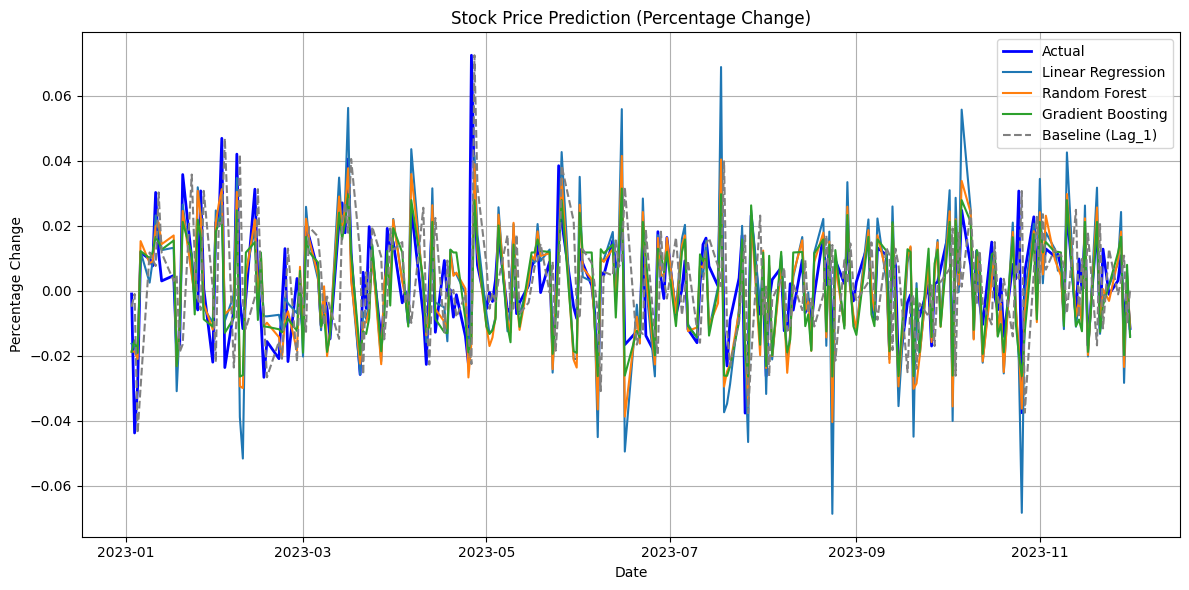

In [26]:


#Visualize predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label='Actual', color='blue', linewidth=2)
for name, result in results.items():
    if name != "Baseline (Lag_1)":
        preds = result["Model"].predict(X_test)
        plt.plot(y_test.index, preds, label=name)
plt.plot(y_test.index, y_test_baseline.values, label="Baseline (Lag_1)", linestyle='--', color='gray')
plt.title("Stock Price Prediction (Percentage Change)")
plt.xlabel("Date")
plt.ylabel("Percentage Change")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [56]:
# Check the number of rows and columns after preprocessing
print(f"Number of instances (rows): {data.shape[0]}")
print(f"Number of attributes (columns): {data.shape[1]}")


Number of instances (rows): 3511
Number of attributes (columns): 19


---

# For report visualisations

## Figure 2.1 Adjusted Close Price Trend

Placement: Section 2.1: Data Description


This visualization provides an overview of the stock's performance over time, setting the context for the analysis.

Purpose: Demonstrates the overall growth and fluctuations in Microsoft's stock prices, which the machine learning models aim to predict.


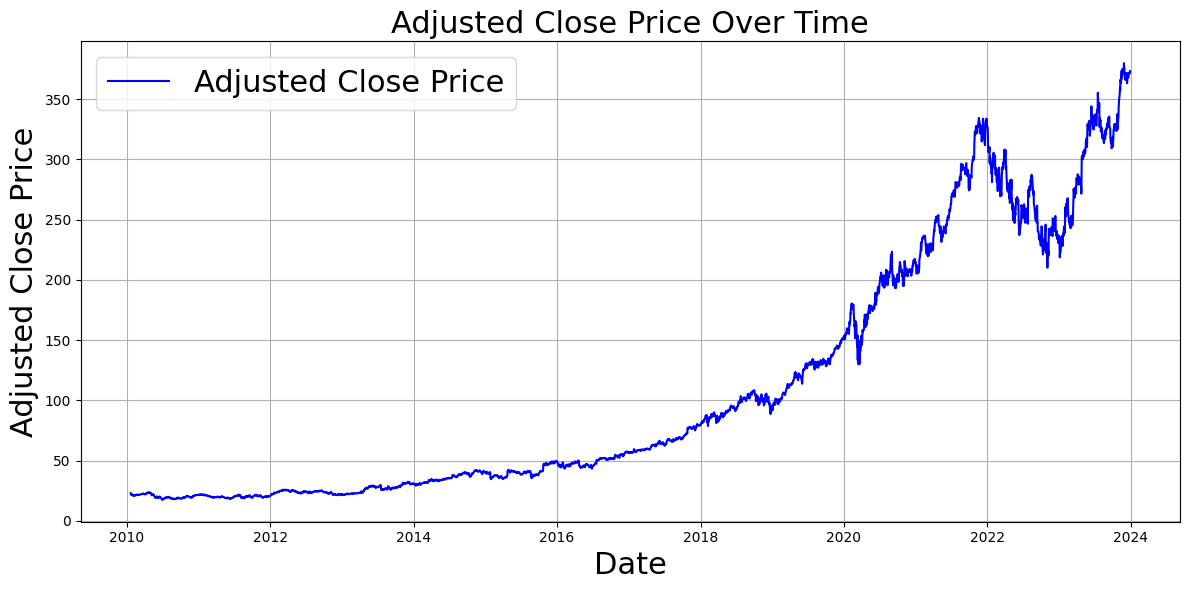

In [72]:
# Adjusted Close Price Trend
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Adj Close'], label="Adjusted Close Price", color="blue")
plt.title("Adjusted Close Price Over Time", fontsize=22)
plt.xlabel("Date", fontsize=22)
plt.ylabel("Adjusted Close Price", fontsize=22)
plt.legend(fontsize=22)
plt.grid(True)
plt.tight_layout()
plt.show()


## Figure 2.2. Distribution of Percentage Change

Placement: Section 2.1: Data Description

This histogram shows the variability of the target variable, helping to illustrate the challenges of predicting percentage changes in stock prices.

Purpose: Highlights the spread and skewness of the target variable.



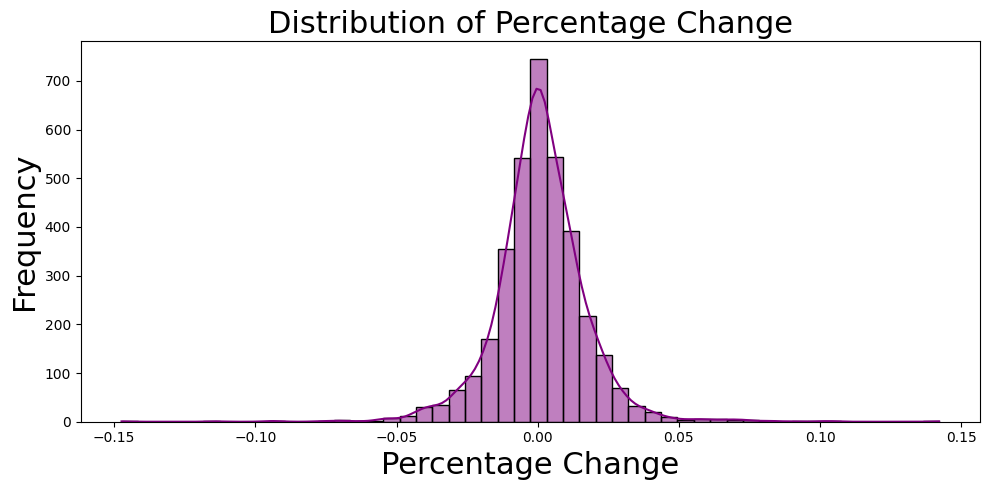

In [73]:
# Distribution of Percentage Change
plt.figure(figsize=(10, 5))
sns.histplot(data['Adj_Close_Pct_Change'], kde=True, bins=50, color="purple")
plt.title("Distribution of Percentage Change", fontsize=22)
plt.xlabel("Percentage Change", fontsize=22)
plt.ylabel("Frequency", fontsize=22)
plt.tight_layout()
plt.show()


## Figure 2.3. Correlation Heatmap

Placement: Section 2.2: Data Understanding

This plot shows the relationships between features and the target variable.

Purpose: Supports feature selection by demonstrating which features are most correlated with the target variable.

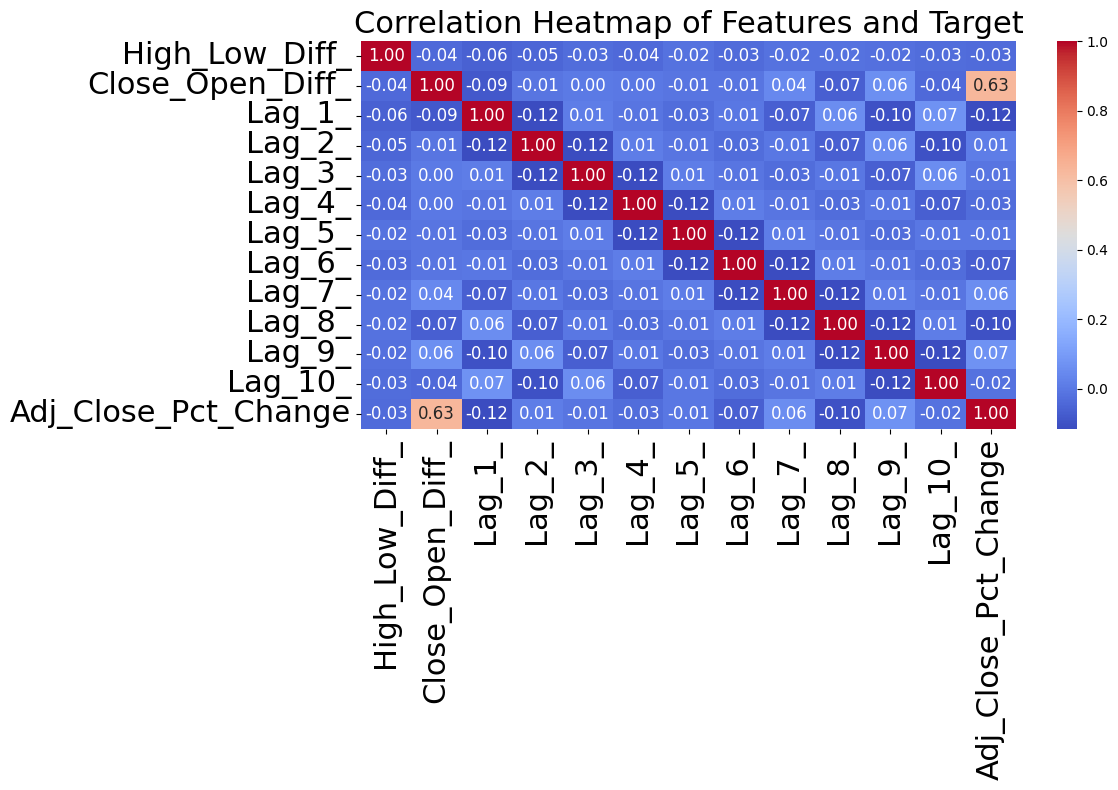

In [101]:
# Flatten multi-level index if it exists in X_train
if isinstance(X_train.columns, pd.MultiIndex):
    X_train.columns = ['_'.join(map(str, col)).strip() for col in X_train.columns]

# Compute the correlation matrix
correlation_matrix = pd.concat([X_train, y_train.rename("Adj_Close_Pct_Change")], axis=1).corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, annot_kws={"fontsize": 12})
plt.title("Correlation Heatmap of Features and Target", fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.tight_layout()
plt.show()


## Fig 3.1, 3.2, 3.3 Feature Importance

Placement: Section 4: Experiments

After discussing the models and their predictive performance.

Purpose: Explains the decision-making process of Random Forest, Gradient Boosting, and Linear Regression models by showing which features contributed most to their predictions.


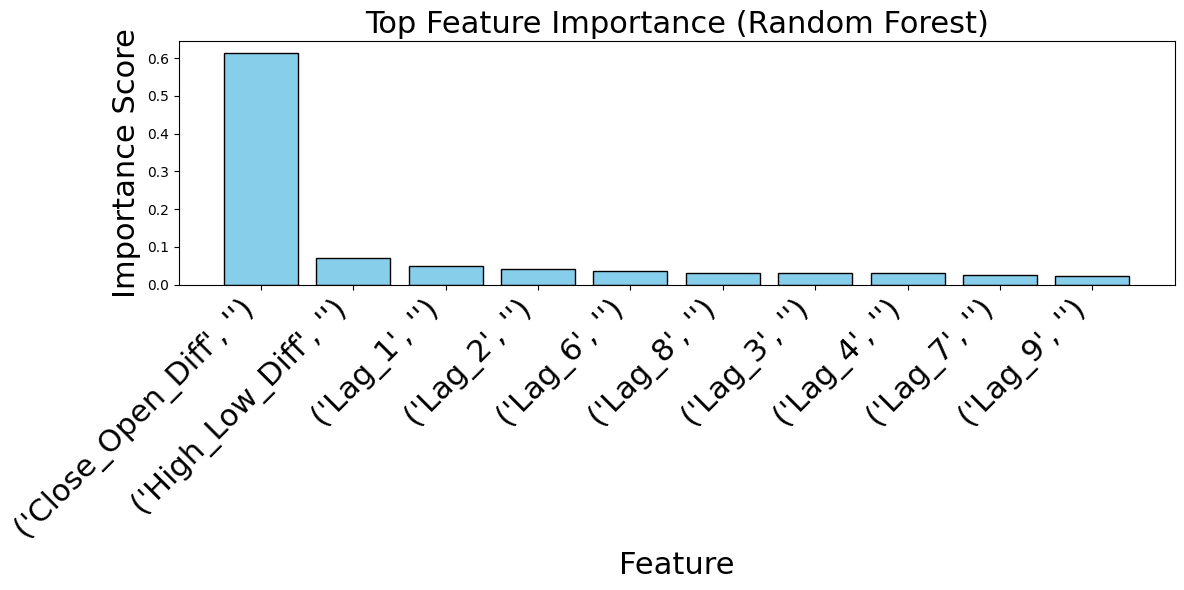

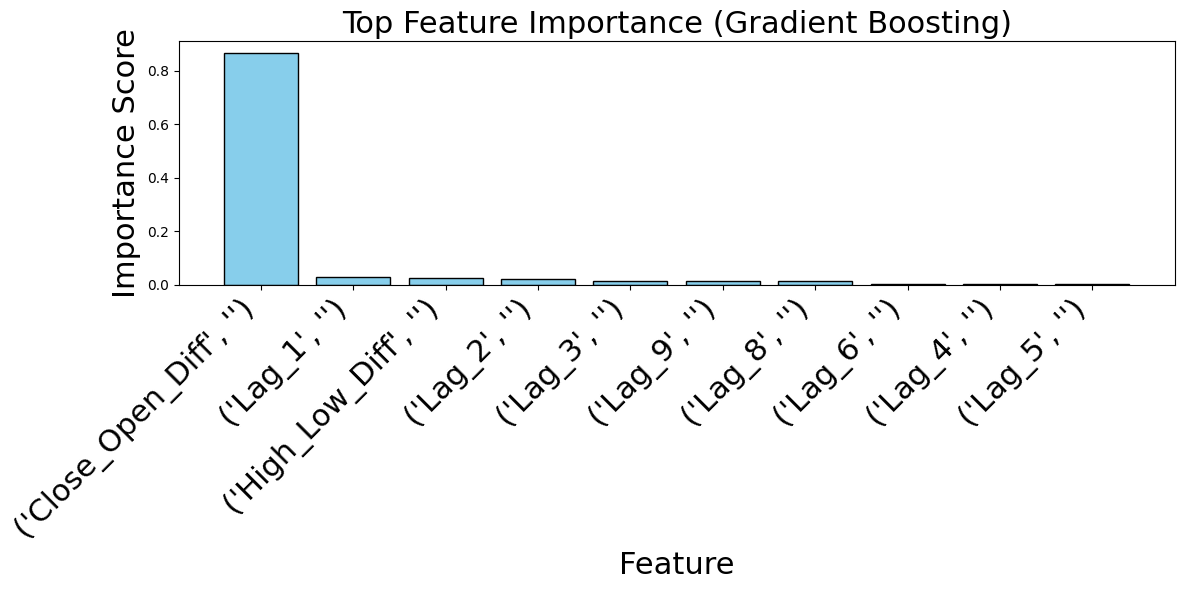

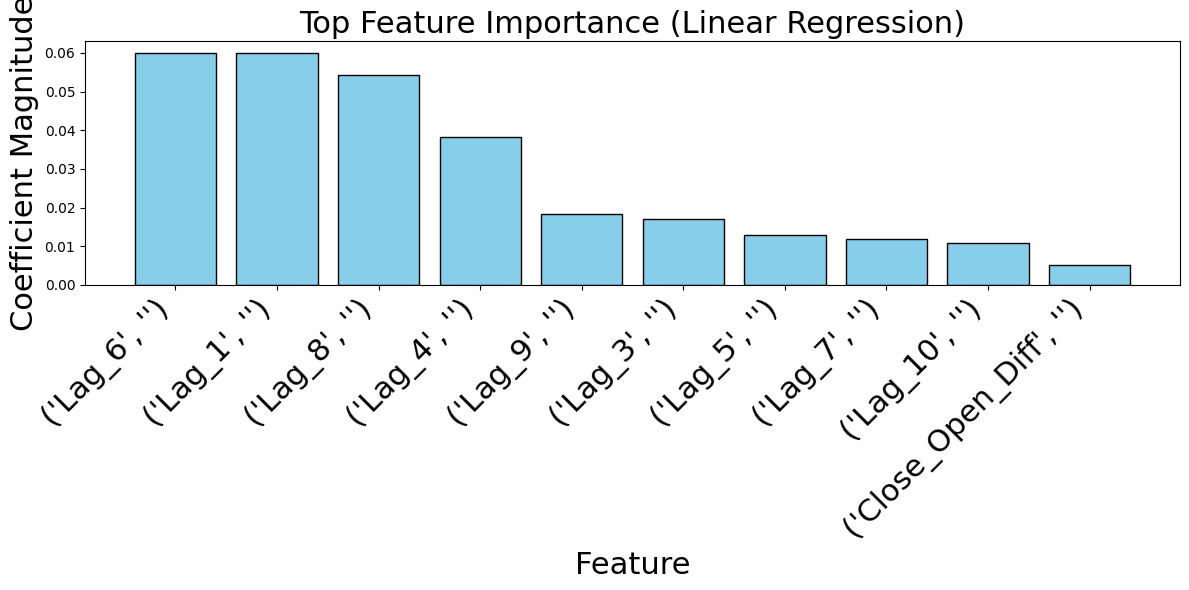

In [95]:
# Feature Importance
top_k = 10
for model_name, importances in importances_dict.items():
    indices = np.argsort(importances)[::-1]
    feature_names = X_train.columns

    plt.figure(figsize=(12, 6))
    plt.title(f"Top Feature Importance ({model_name})", fontsize=22)
    plt.bar(range(top_k), importances[indices][:top_k], align="center", color="skyblue", edgecolor="black")
    plt.xticks(range(top_k), np.array(feature_names)[indices][:top_k], rotation=45, ha="right", fontsize=22)
    plt.xlabel("Feature", fontsize=22)
    plt.ylabel("Importance Score" if model_name != "Linear Regression" else "Coefficient Magnitude", fontsize=22)
    plt.tight_layout()
    plt.show()


## Fig 4.2 Prediction Comparisons

Placement: Section 4: Experiments

description of model performance and hyperparameter tuning.

Purpose: Clearly illustrates how well each model tracks the actual percentage changes, comparing their relative performance.

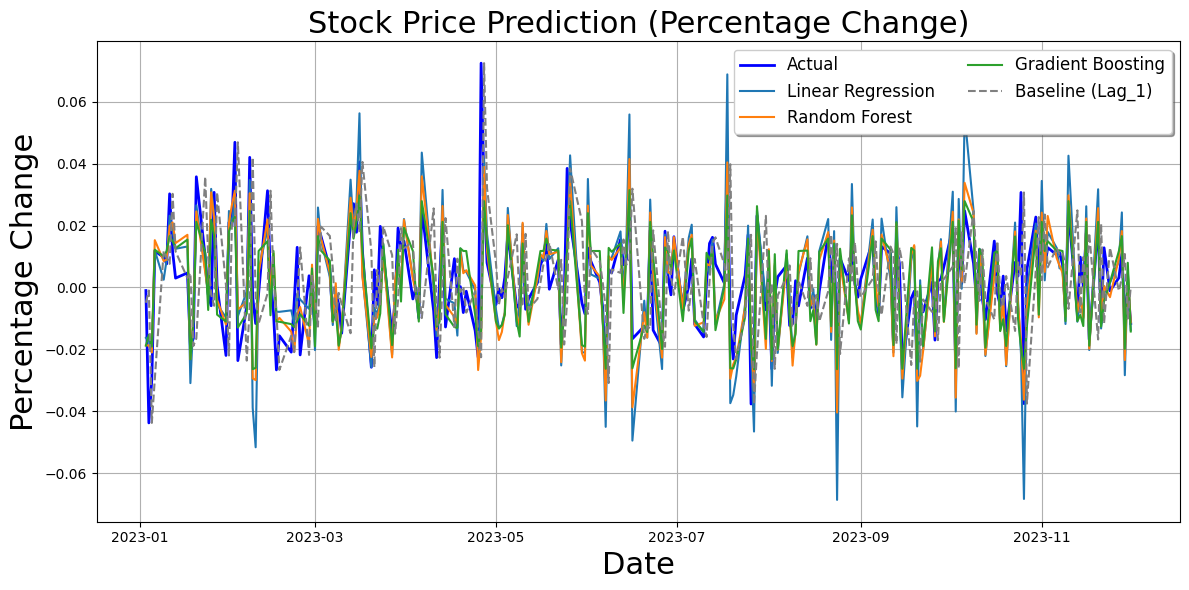

In [94]:
# Prediction Comparisons
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label='Actual', color='blue', linewidth=2)
for name, result in results.items():
    if name != "Baseline (Lag_1)":
        preds = result["Model"].predict(X_test)
        plt.plot(y_test.index, preds, label=name)
plt.plot(y_test.index, y_test_baseline.values, label="Baseline (Lag_1)", linestyle='--', color='gray')
plt.title("Stock Price Prediction (Percentage Change)", fontsize=22)
plt.xlabel("Date", fontsize=22)
plt.ylabel("Percentage Change", fontsize=22)
plt.legend(fontsize=12, loc="upper right", ncol=2, shadow=True,) 
plt.grid(True)
plt.tight_layout()
plt.show()


## Fig 4.2 Residual Analysis

Placement: Section 4: Experiments

After discussing prediction accuracy and feature importance.

Purpose: Highlights where each model performs well or poorly by showing the distribution and magnitude of prediction errors over the testing period.

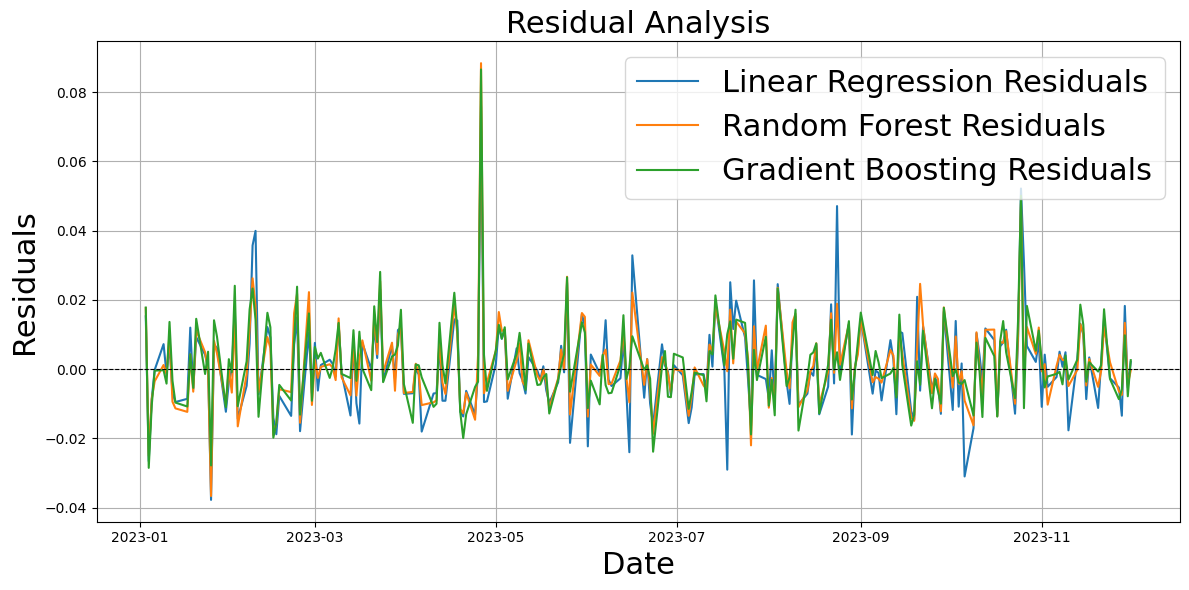

In [96]:
# Residual Analysis
plt.figure(figsize=(12, 6))
for name, result in results.items():
    if name != "Baseline (Lag_1)":
        residuals = y_test.values - result["Model"].predict(X_test)
        plt.plot(y_test.index, residuals, label=f'{name} Residuals')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title("Residual Analysis", fontsize=22)
plt.xlabel("Date", fontsize=22)
plt.ylabel("Residuals", fontsize=22)
plt.legend(fontsize=22)
plt.grid(True)
plt.tight_layout()
plt.show()


## Fig 5.1 Performance Summary Table (not included)

Placement: Section 4: Experiments

Include this at the beginning or end of the experiments section.

Purpose: Summarizes the performance of all models and the baseline approach, allowing for quick and clear comparisons.

<Figure size 1000x600 with 0 Axes>

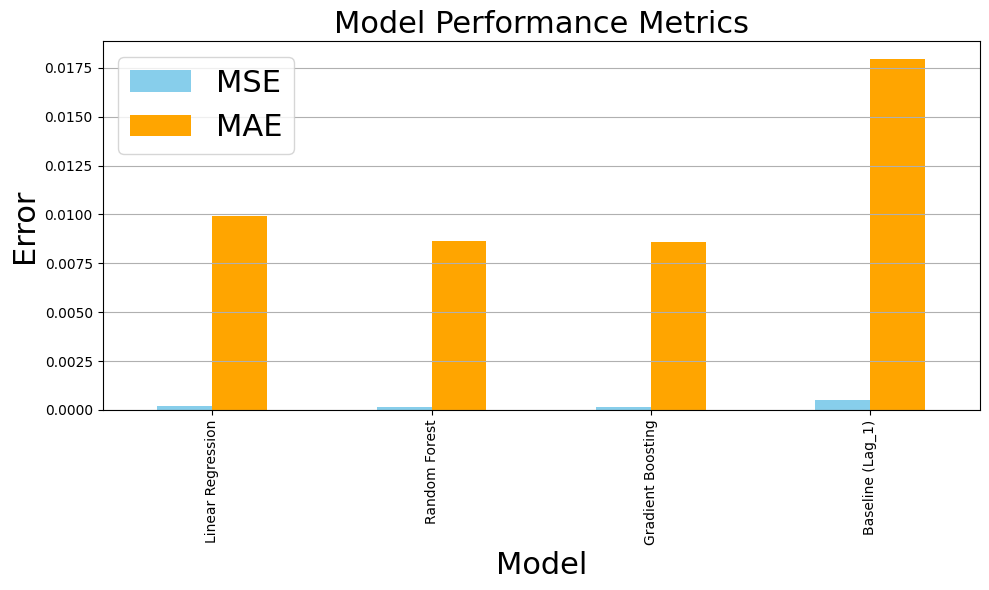

In [97]:
# Visualization of Performance Summary Table
plt.figure(figsize=(10, 6))
performance_df.set_index("Model")[["MSE", "MAE"]].plot(kind="bar", figsize=(10, 6), color=["skyblue", "orange"])
plt.title("Model Performance Metrics", fontsize=22)
plt.ylabel("Error", fontsize=22)
plt.xlabel("Model", fontsize=22)
plt.legend(["MSE", "MAE"], fontsize=22)
plt.grid(axis="y")
plt.tight_layout()
plt.show()
